## Import Libraries

In [1]:
!pip install awswrangler

In [2]:
import awswrangler as wr
import boto3

mybucket = 'dlocal-eu1-office-live-sagemaker-aons'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import decimal
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## Upload Data Base

In [4]:
query = '''

select
    ml.case_id,
    ca.bin,
    ca.brand,
    ca.category,
    rc.usd_amount,
    rc.online_verdict,
    cc.result,
    case
        when rc.online_verdict_reason like '%Positive%'then 1
        else 0
    end as flag_PU,
    case
        when id_chargeback is not null then 1
        else 0
    end as flag_cbk,
    ml.pred_score,
    (array_max(transform(siv.same_card.same_card.approved.transaction_hours, x -> cast(x as int))))/24 card_age_days

from risk.risk_risk_case rc

join "dlocal-eu1-office-live-machine-learning"."saas_test_dataset_new_merchants_20211004" ml
    on ml.case_id = rc.case_id
    
left join risk.risk_card ca
    on ca.card_id = rc.card_id

left join risk.risk_risk_case_collect cc
    on cc.case_id = rc.case_id

left join default.merchant_data_pf md
    on rc.merchant_reference = md.merchant_reference
    and rc.country_code = md.country_code

left join dl_db_master.unipay_chargebacks cbk 
    on rc.ticket_id = cbk.id_boleto
    and cc.result='ACCEPT'

left join "datalake_lookout"."sherlock_initial" si 
    on cast(rc.case_id as varchar) = si."data.input.transaction.case_id"

left join "datalake_lookout"."sherlock_initial_velocities" siv
    on siv.sherlock_initial_id = si.id

where rc.merchant_reference = '30630'
    and rc.operation_type in('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
    and rc.created_date between date '2021-04-17' and date '2021-09-15'
;

'''

In [5]:
%%time

df_original = wr.athena.read_sql_query(
    sql=query,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-aons/dev'
)

CPU times: user 42 s, sys: 1.58 s, total: 43.6 s
Wall time: 8min 59s


In [6]:
df_original['case_id'] = df_original.case_id.astype(str)

print('shape --->', df_original.shape)
print('')
print(df_original.info())

shape ---> (1818507, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818507 entries, 0 to 1818506
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   case_id         object 
 1   bin             string 
 2   brand           string 
 3   category        string 
 4   card_age_days   Int32  
 5   usd_amount      object 
 6   online_verdict  string 
 7   result          string 
 8   flag_PU         Int32  
 9   flag_cbk        Int32  
 10  pred_score      float32
dtypes: Int32(3), float32(1), object(2), string(5)
memory usage: 130.1+ MB
None


In [7]:
df_original.sample(10)

,case_id,bin,brand,category,card_age_days,usd_amount,online_verdict,result,flag_PU,flag_cbk,pred_score
1366844,659752995,516292,MC,PLATINUM,36,6.84,ACCEPT,ACCEPT,0,0,0.05
242568,801397991,511781,MC,GOLD,<NA>,1.16,ACCEPT,REJECT,0,0,196.80
183908,719578468,423154,VI,PLATINUM,<NA>,6.94,ACCEPT,REJECT,0,0,852.29
1478218,883277872,544731,MC,GOLD,<NA>,17.20,ACCEPT,REJECT,0,0,299.56
1096248,1007530380,417401,VI,CLASSIC,92,6.54,ACCEPT,ACCEPT,1,0,0.14
852950,840375339,516292,MC,PLATINUM,33,6.69,ACCEPT,REJECT,1,0,558.69
1547362,912305703,466079,VI,PLATINUM,<NA>,1.14,ACCEPT,REJECT,0,0,400.52
1368012,887142707,549622,MC,PREPAID,492,6.68,ACCEPT,REJECT,1,0,711.23
518114,698476669,230650,MC,GOLD,13,1.19,ACCEPT,REJECT,0,0,85.64
338967,910718648,512707,MC,STANDARD,18,6.62,ACCEPT,ACCEPT,0,0,882.59


In [8]:
df_original.value_counts('online_verdict')

online_verdict
ACCEPT    1780333
REJECT      38143
dtype: int64

In [9]:
df_original.value_counts('result')

result
REJECT       1025460
ACCEPT        788766
AUTHORIZE       4257
dtype: int64

In [10]:
df_original.value_counts('flag_cbk')

flag_cbk
0    1814190
1       4317
dtype: int64

In [11]:
df_original.value_counts('flag_PU')

flag_PU
0    1411495
1     407012
dtype: int64

## Cast usd_amount

In [12]:
df_original.dtypes

case_id            object
bin                string
brand              string
category           string
card_age_days       Int32
usd_amount         object
online_verdict     string
result             string
flag_PU             Int32
flag_cbk            Int32
pred_score        float32
dtype: object

In [13]:
df_original=df_original.astype({'usd_amount': 'float32'})

In [14]:
df_original.dtypes

case_id            object
bin                string
brand              string
category           string
card_age_days       Int32
usd_amount        float32
online_verdict     string
result             string
flag_PU             Int32
flag_cbk            Int32
pred_score        float32
dtype: object

## Score Ranges

In [146]:
df_original.columns

Index(['case_id', 'bin', 'brand', 'category', 'card_age_days', 'usd_amount',
       'online_verdict', 'result', 'flag_PU', 'flag_cbk', 'pred_score'],
      dtype='object')

In [147]:
df = df_original[['case_id', 'bin', 'brand', 'category', 'card_age_days', 'usd_amount', 'online_verdict',
       'result', 'flag_PU', 'flag_cbk', 'pred_score']]

In [148]:
def agrupar_score_inhouse():
    
    values_list_inhouse = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 
                           500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

    conditions_inhouse = []

    for i in values_list_inhouse:
        if i == 0:
            condicion = (df['pred_score'] == 0)
            conditions_inhouse.append(condicion)
        else:
            condicion = (df['pred_score'] < i)
            conditions_inhouse.append(condicion)
            
    df['score_group'] = np.select(conditions_inhouse, values_list_inhouse)
    
agrupar_score_inhouse()

In [149]:
df.head()

,case_id,bin,brand,category,card_age_days,usd_amount,online_verdict,result,flag_PU,flag_cbk,pred_score,score_group
0,780983337,485464,VI,CLASSIC,<NA>,1.14,ACCEPT,REJECT,0,0,256.68,275
1,782805770,550209,MC,GOLD,<NA>,1.14,ACCEPT,REJECT,0,0,440.17,450
2,809437932,542820,MC,STANDARD,<NA>,1.17,ACCEPT,REJECT,0,0,186.23,200
3,773955281,550209,MC,GOLD,<NA>,6.69,ACCEPT,ACCEPT,0,0,752.65,775
4,880124039,534520,MC,STANDARD,<NA>,6.67,ACCEPT,ACCEPT,0,0,0.10,25


## Card Age Ranges

In [150]:
df['card_age_days'].fillna(0, inplace=True)

In [151]:
df['card_age_range'] = df.apply(lambda x:'>90' if x['card_age_days']>= 90 else('>30' if  x['card_age_days']>=30 else('>10' if  x['card_age_days']>=10 else('>2' if  x['card_age_days']>=2 else('<2' if  x['card_age_days']>0 else '0')))),axis=1)


In [152]:
df.value_counts('card_age_range')

card_age_range
0      1066716
>30     339634
>90     330587
>10      68207
>2       11608
<2        1755
dtype: int64

## Filter Positive Users

In [153]:
df=df[df['flag_PU']==0]
df.value_counts('flag_PU')

flag_PU
0    1411495
dtype: int64

In [154]:
df.drop(columns=['flag_PU'], inplace=True)

In [155]:
df.sample(5)

,case_id,bin,brand,category,card_age_days,usd_amount,online_verdict,result,flag_cbk,pred_score,score_group,card_age_range
604394,614922531,453211,VI,GOLD,0,6.58,ACCEPT,ACCEPT,0,773.49,775,0
1173467,699546515,510168,MC,STANDARD,0,6.89,ACCEPT,ACCEPT,0,848.60,850,0
643371,853789446,410863,VI,GOLD,0,1.16,ACCEPT,REJECT,0,229.53,250,0
227094,806897375,550209,MC,GOLD,0,6.86,ACCEPT,ACCEPT,0,0.06,25,0
566731,884199719,523284,MC,STANDARD,0,1.16,ACCEPT,REJECT,0,215.44,225,0


## Filter dlocal REJECT

In [156]:
df_1=df[df['online_verdict']=='ACCEPT']
df_1.value_counts('online_verdict')

online_verdict
ACCEPT    1373321
dtype: int64

In [157]:
df.drop(columns=['online_verdict'], inplace=True)

In [158]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'card_age_days', 'usd_amount',
       'result', 'flag_cbk', 'pred_score', 'score_group', 'card_age_range'],
      dtype='object')

## Card Age

In [275]:
df_1=df[['card_age_range','result','usd_amount']]

In [276]:
card_age = pd.pivot_table(df_1, values='usd_amount', index=['card_age_range'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [277]:
card_age.head(3)

result,ACCEPT,AUTHORIZE,REJECT
card_age_range,,,
0,"4,983,215.50","19,199.34","9,011,740.00"
<2,"8,880.96",12.49,"6,732.50"
>10,"297,211.38","1,071.77","252,782.17"


<AxesSubplot:title={'center':'Score vs Others'}, xlabel='card_age_range', ylabel='USD [MM]'>

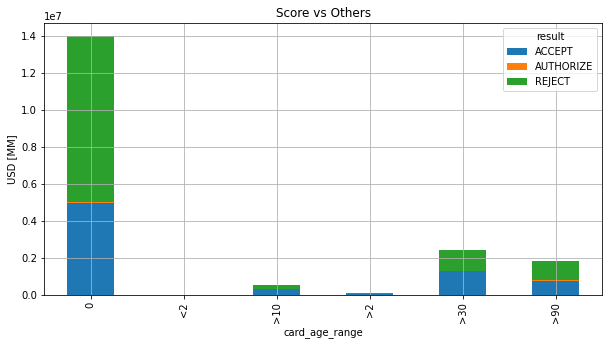

In [278]:
card_age.plot(kind='bar',
        title = 'Score vs Others',
        ylabel = 'USD [MM]',
        figsize = (10,5),
        grid = True,
        stacked = True)

## Filter Card Age Range

In [279]:
df_0=df[df['card_age_range']=='0']
df_0.value_counts('card_age_range')

card_age_range
0    946349
dtype: int64

## Score vs Fianl Result

In [280]:
df_1=df[['score_group','result','usd_amount']]

In [281]:
score_result = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [282]:
score_result.head(4)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"3,134,057.50","9,780.90","2,899,557.25"
50,610.81,4.62,"2,886.21"
75,"1,016.55",15.45,"6,134.04"
100,"1,973.96",47.06,"12,316.74"


In [283]:
df0=df_0[['score_group','result','usd_amount']]

score_result_0 = pd.pivot_table(df0, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

<AxesSubplot:title={'center':'Scores vs App Fianl [0]'}, xlabel='score_group', ylabel='USD [MM]'>

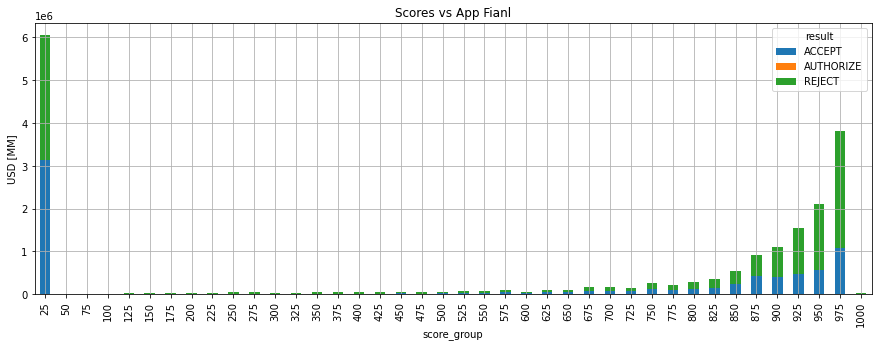

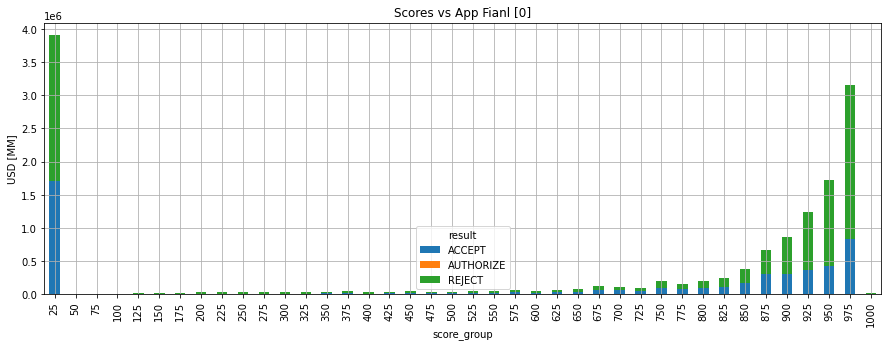

In [284]:
score_result.plot(kind='bar',
        title = 'Scores vs App Fianl',
        ylabel = 'USD [MM]',
        figsize = (15,5),
        grid = True,
        stacked = True)

score_result_0.plot(kind='bar',
        title = 'Scores vs App Fianl [0]',
        ylabel = 'USD [MM]',
        figsize = (15,5),
        grid = True,
        stacked = True)

## Card Brand

In [288]:
df_1=df[['brand','result','usd_amount']]

In [289]:
card_brand = pd.pivot_table(df_1, values='usd_amount', index=['brand'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [290]:
card_brand.head(4)

result,ACCEPT,AUTHORIZE,REJECT
brand,,,
AE,"50,835.25",185.09,"53,874.31"
EL,"93,598.30",375.43,"193,867.34"
HI,211.32,0.00,"2,584.18"
MC,"4,975,834.00","18,896.54","7,643,346.50"


In [292]:
df0=df_0[['brand','result','usd_amount']]

card_brand_0 = pd.pivot_table(df0, values='usd_amount', index=['brand'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

<AxesSubplot:title={'center':'App Final vs Brand [0]'}, xlabel='brand', ylabel='USD [MM]'>

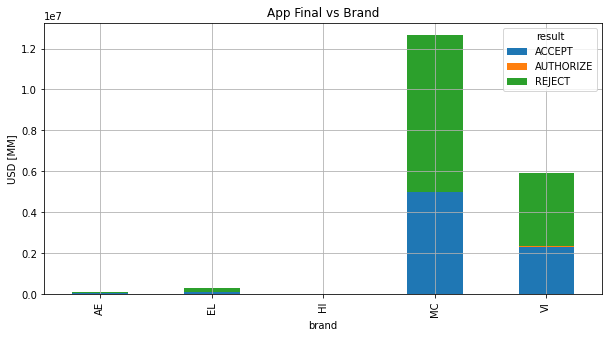

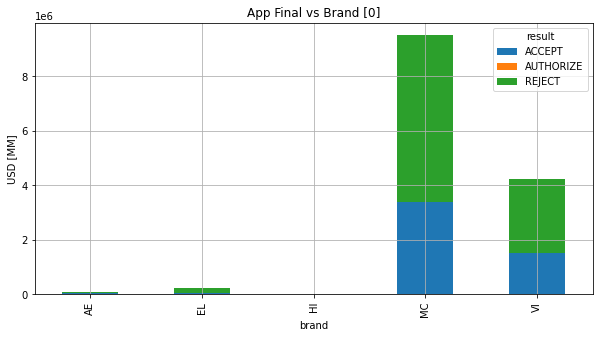

In [293]:
card_brand.plot(kind='bar',
        title = 'App Final vs Brand',
        ylabel = 'USD [MM]',
        figsize = (10,5),
        grid = True,
        stacked = True)

card_brand_0.plot(kind='bar',
        title = 'App Final vs Brand [0]',
        ylabel = 'USD [MM]',
        figsize = (10,5),
        grid = True,
        stacked = True)

## Card Category

In [174]:
df_1=df[['category','result','usd_amount']]

In [175]:
df_1.head(3)

,category,result,usd_amount
0,CLASSIC,REJECT,1.14
1,GOLD,REJECT,1.14
2,STANDARD,REJECT,1.17


In [176]:
table = pd.pivot_table(df_1, values='usd_amount', index=['category'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [177]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
category,,,
ACQUIRER ONLY,0.00,0.00,50.94
ALIMENTACAO,0.00,0.00,1.15
B2B,0.00,0.00,6.78
BASIC,0.00,0.00,2.31


<AxesSubplot:title={'center':'App Final vs Category'}, xlabel='category', ylabel='USD [MM]'>

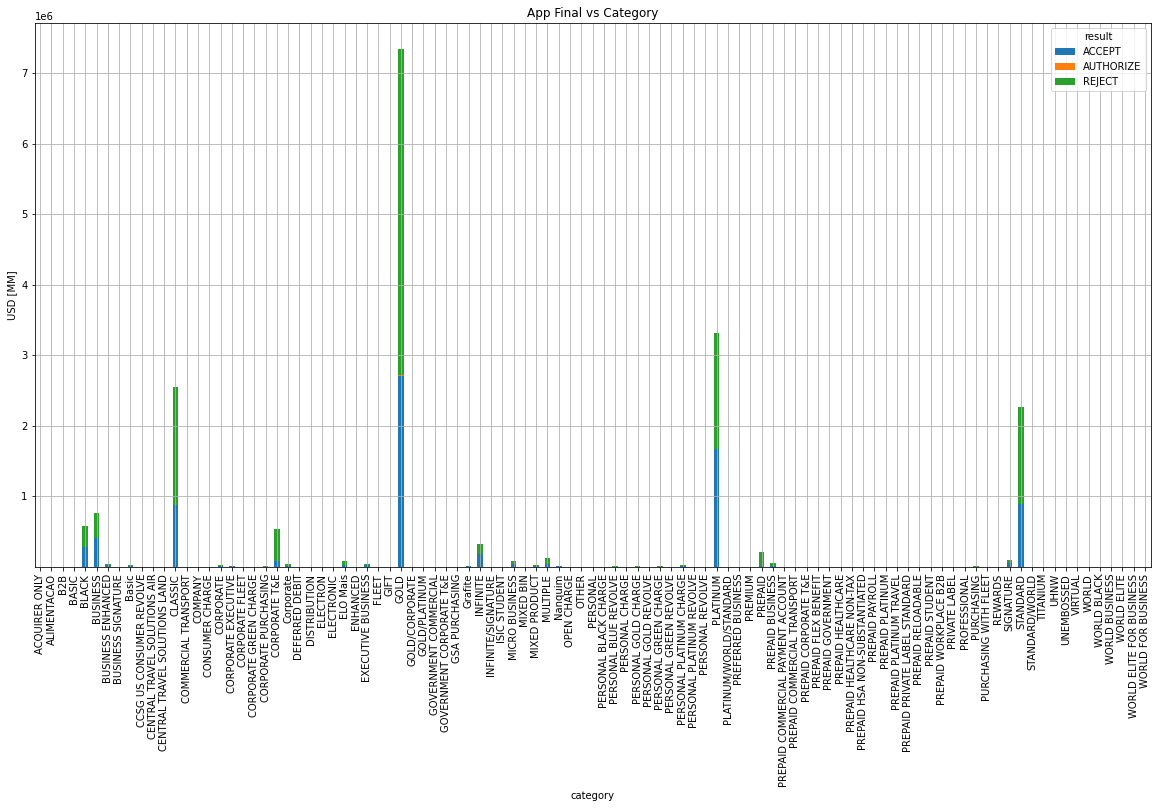

In [178]:
table.plot(kind='bar',
        title = 'App Final vs Category',
        ylabel = 'USD [MM]',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Classic Cards

In [294]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'card_age_days', 'usd_amount',
       'result', 'flag_cbk', 'pred_score', 'score_group', 'card_age_range'],
      dtype='object')

In [295]:
df_1=df[df['category']=='CLASSIC']
df_1.value_counts('category')

category
CLASSIC    189507
dtype: int64

In [296]:
df_1=df_1[['score_group','result','usd_amount']]

In [297]:
classic = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [298]:
classic.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"377,102.84","1,171.85","414,058.03"
50,21.22,0.00,400.82
75,37.18,3.45,"1,229.14"


In [299]:
df0=df_0[df_0['category']=='CLASSIC']

df0=df0[['score_group','result','usd_amount']]

classic_0 = pd.pivot_table(df0, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

<AxesSubplot:title={'center':'Score vs Classic [0]'}, xlabel='score_group', ylabel='USD'>

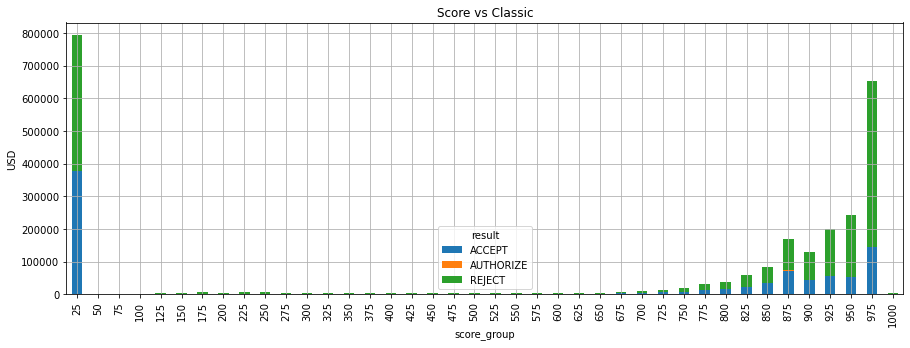

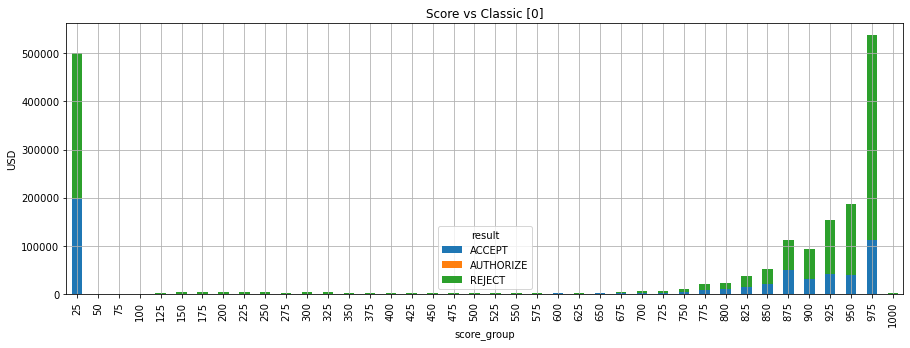

In [300]:
classic.plot(kind='bar',
        title = 'Score vs Classic',
        ylabel = 'USD',
        figsize = (15,5),
        grid = True,
        stacked = True)

classic_0.plot(kind='bar',
        title = 'Score vs Classic [0]',
        ylabel = 'USD',
        figsize = (15,5),
        grid = True,
        stacked = True)

## Filter Gold Cards

In [301]:
df_1=df[df['category']=='GOLD']
df_1.value_counts('category')

category
GOLD    589197
dtype: int64

In [302]:
df_1=df_1[['score_group','result','usd_amount']]

In [303]:
gold = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [304]:
gold.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"1,159,979.00","3,890.91","1,236,840.25"
50,323.45,1.15,"1,273.64"
75,496.58,5.54,"2,372.86"


In [305]:
df0=df_0[df_0['category']=='GOLD']

df0=df0[['score_group','result','usd_amount']]

gold_0 = pd.pivot_table(df0, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

<AxesSubplot:title={'center':'Score vs Gold [0]'}, xlabel='score_group', ylabel='USD'>

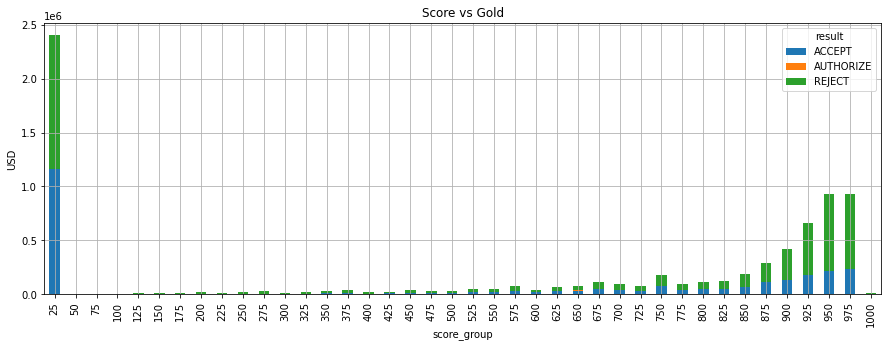

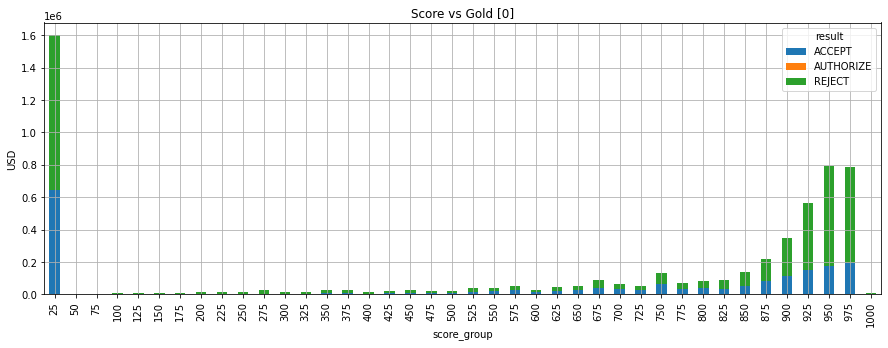

In [306]:
gold.plot(kind='bar',
        title = 'Score vs Gold',
        ylabel = 'USD',
        figsize = (15,5),
        grid = True,
        stacked = True)

gold_0.plot(kind='bar',
        title = 'Score vs Gold [0]',
        ylabel = 'USD',
        figsize = (15,5),
        grid = True,
        stacked = True)

## Filter Standard Cards

In [191]:
df_1=df[df['category']=='STANDARD']
df_1.value_counts('category')

category
STANDARD    178749
dtype: int64

In [192]:
df_1=df_1[['score_group','result','usd_amount']]

In [193]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [194]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"387,339.84","1,180.98","346,256.78"
50,7.58,1.15,246.51
75,74.94,0.00,387.82


<AxesSubplot:title={'center':'Score vs Standard'}, xlabel='score_group', ylabel='USD'>

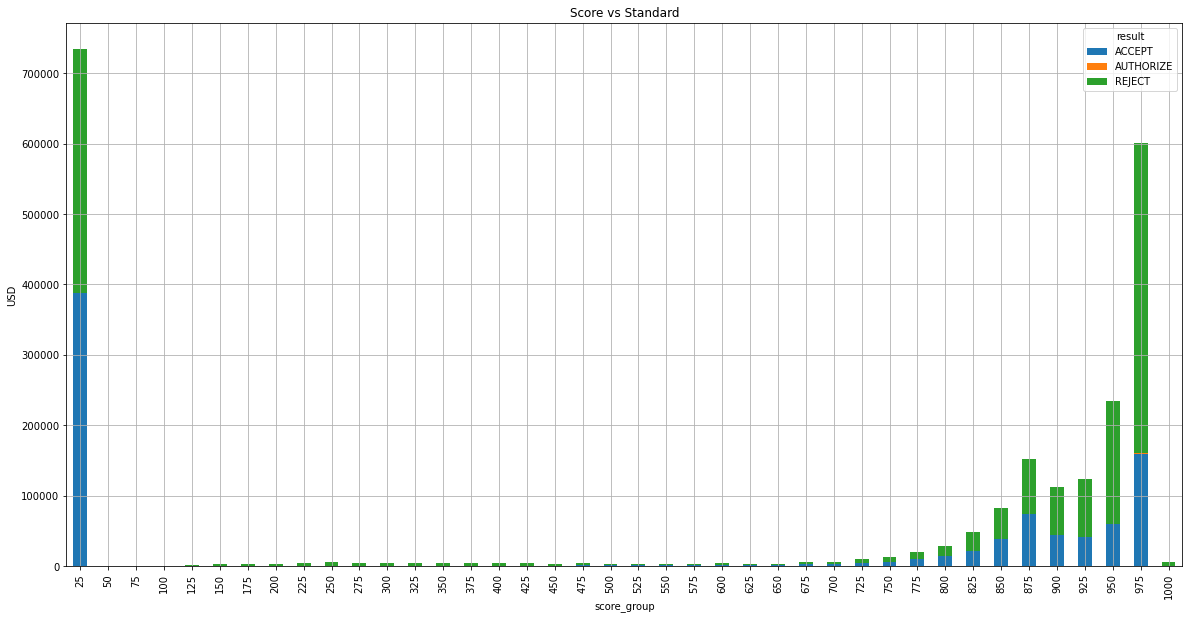

In [195]:
table.plot(kind='bar',
        title = 'Score vs Standard',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Corporate T&E Cards

In [196]:
df_1=df[df['category']=='CORPORATE T&E']
df_1.value_counts('category')

category
CORPORATE T&E    39507
dtype: int64

In [197]:
df_1=df_1[['score_group','result','usd_amount']]

In [198]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [199]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"31,021.72",74.07,"117,068.96"
50,1.85,0.00,151.06
75,20.26,4.12,576.46


<AxesSubplot:title={'center':'Score vs Corporate T&E'}, xlabel='score_group', ylabel='USD'>

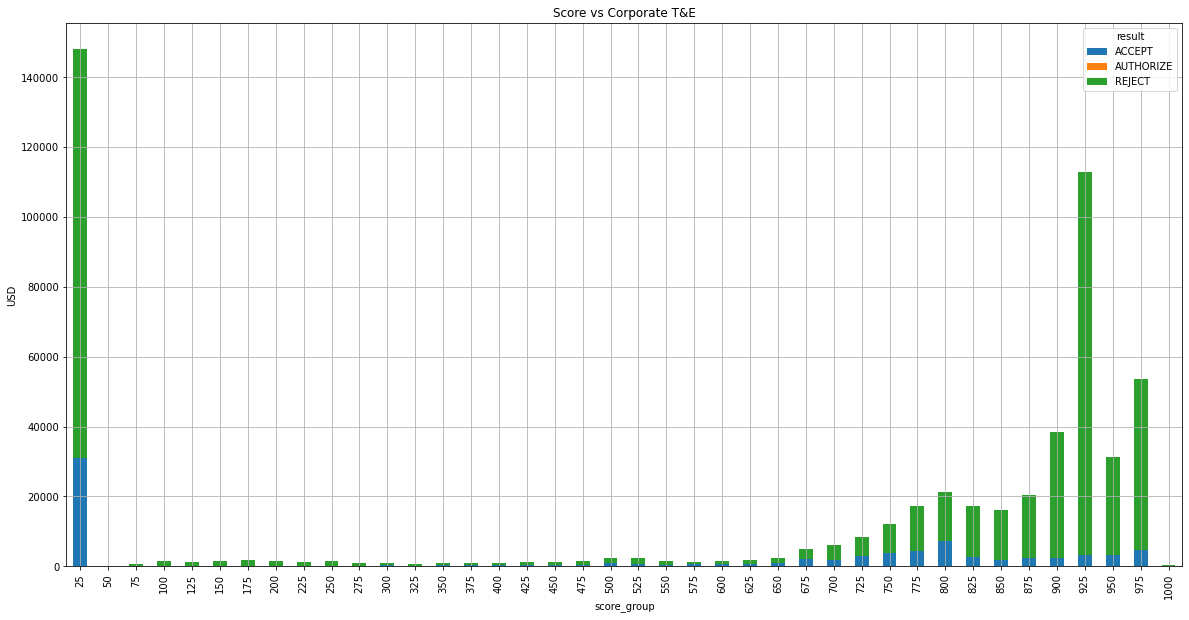

In [200]:
table.plot(kind='bar',
        title = 'Score vs Corporate T&E',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Others

In [201]:
df_1=df[df['category']!='CLASSIC']
df_1=df_1[df_1['category']!='GOLD']
df_1=df_1[df_1['category']!='STANDARD']
df_1=df_1[df_1['category']!='PLATINUM']
df_1=df_1[df_1['category']!='BLACK']
df_1=df_1[df_1['category']!='INFINITE']
df_1=df_1[df_1['category']!='SIGNATURE']
df_1.value_counts('category')

category
BUSINESS                              47023
CORPORATE T&E                         39507
PREPAID                               16995
MICRO BUSINESS                         7985
MULTIPLE                               6628
ELO Mais                               4718
PREPAID BUSINESS                       4045
Corporate                              2314
MIXED PRODUCT                          2123
EXECUTIVE BUSINESS                     1968
BUSINESS ENHANCED                      1872
PERSONAL PLATINUM CHARGE               1781
Basic                                  1391
Nanquim                                 798
CORPORATE                               784
Grafite                                 654
PERSONAL GOLD CHARGE                    514
PERSONAL BLUE REVOLVE                   473
PERSONAL GREEN CHARGE                   423
CORPORATE PURCHASING                    337
CORPORATE EXECUTIVE                     317
ELECTRON                                279
PERSONAL REVOLVE       

In [202]:
df_1=df_1[['score_group','result','usd_amount']]

In [203]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [204]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"299,482.97","1,162.26","322,791.38"
50,16.18,0.00,319.36
75,29.13,5.28,687.17


<AxesSubplot:title={'center':'Score vs Others'}, xlabel='score_group', ylabel='USD'>

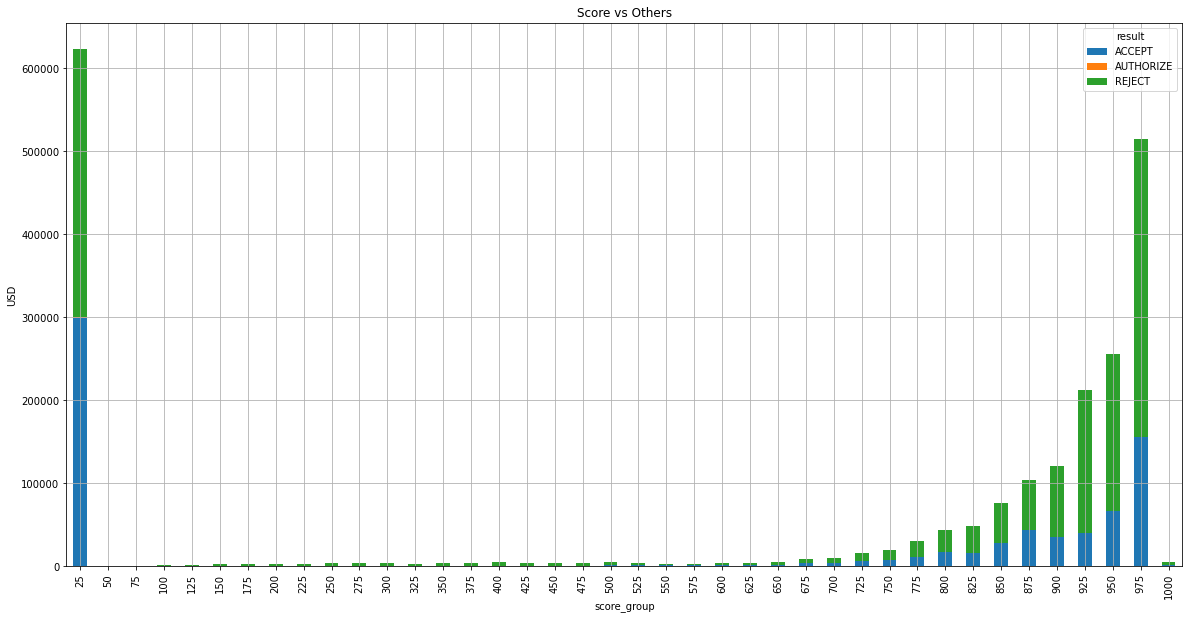

In [205]:
table.plot(kind='bar',
        title = 'Score vs Others',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## BINs Classic Cards

In [58]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'usd_amount', 'result',
       'flag_cbk', 'pred_score', 'score_group'],
      dtype='object')

In [60]:
df_1=df[df['category']=='CLASSIC']
df_1.value_counts('category')

category
CLASSIC    189507
dtype: int64

In [61]:
df_1=df[['bin','result','usd_amount']]

In [62]:
table = pd.pivot_table(df_1, values='usd_amount', index=['bin'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [63]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
bin,,,
222738,0.00,0.00,1.16
222746,0.00,0.00,0.99
222763,"15,884.25",56.40,"34,509.30"


## Pivote Table BIN

In [65]:
df_1=df[['bin','result','usd_amount']]

In [66]:
df_1.head(4)

,bin,result,usd_amount
0,474525,REJECT,1.98
1,544891,REJECT,71.05
2,516306,REJECT,1.18
3,453211,ACCEPT,6.66


In [67]:
table = pd.pivot_table(df_1, values='usd_amount', index=['bin'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [68]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
bin,,,
222738,0.00,0.00,1.16
222746,0.00,0.00,0.99
222763,"15,884.25",56.40,"34,509.30"
222768,0.00,0.00,2.28
